# Importing dependencies

In [69]:
import napari
from pathlib import Path
import tifffile as tf
from napari.utils import nbscreenshot
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage import measure as ms
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas as pd    
from scipy.spatial.distance import euclidean
from skimage import filters
from skimage import morphology as mp
import datetime
from PIL import Image as PILImage
from PIL.TiffTags import TAGS
# import pickle
from datetime import date, datetime
from math import ceil
# from qtpy.QtCore import QTimer
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from IPython.display import Image
import seaborn as sns

now = datetime.now()
current_time = now.strftime("%H%M%S")
today = str(date.today()).replace("-", "")
print(f"Today is (YYYYMMDD) {today}.\nThis date will be used to store the date of the results.")
# time = "{}_{}".format(today, current_time)

Today is (YYYYMMDD) 20230701.
This date will be used to store the date of the results.


# Tool Functions 

In [70]:
def printloop(lst, printall=False):
    if len(lst) < 10 and printall==False:
        for ix, i in enumerate(lst):
            print(ix, i)
    elif printall:
        for ix, i in enumerate(lst):
            print(ix, i)
    else:
        for ix, i in enumerate(lst[:3]):
            print(ix, i)
        print(f"... {len(lst)-3} ...")
        for ix, i in enumerate(lst[-3:]):
            print(len(lst)-2+ix, i)            

def dataframe_division(columns_to_exclude, df1, df2):
    # Divide one DataFrame by another, excluding specific columns
    result = df1.drop(columns=columns_to_exclude) / df2.drop(columns=columns_to_exclude)
    # Merge the excluded columns back into the result DataFrame
    result = pd.concat([df1[columns_to_exclude], result], axis=1)
    return result

def writting_excel(DF, pathname, sheet_name=None):
    """Excel.xlsx"""
    import pandas as pd
    writer = pd.ExcelWriter(pathname, engine='xlsxwriter')
    if type(DF) != type([]):
        if sheet_name == None:
            DF.to_excel(writer, index=None)
        else:
            DF.to_excel(writer, sheet_name=sheet_name, index=None)
        writer.save()
    else:
        for ix, each in enumerate(DF):
            if sheet_name == None:
                DF[ix].to_excel(writer, header=None, index=None)
            else:
                DF[ix].to_excel(writer, sheet_name=sheet_name[ix], index=None)
        writer.save()

## Classes

In [71]:
class ImObject:
    """
    Image Object for 1 single path
    """
    def __init__(self, path):
        self.path = Path(path)
        self.stem = self.path.stem
        self.name = self.path.name
        self.im = tf.imread(path)
        self.shape = self.im.shape
        self.pixelsize = dict(zip(["y", "x", "z"], self.extract_metaTiFF(self.path)))
        self.maxp = np.max(self.im, axis=0)
        
    def extract_metaTiFF(self, path):
        """
        Extract metadata from the first image of the set, ref= Image of reference
        """
        with PILImage.open(str(path)) as img:
            meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

        # interval = [float(i.lstrip("finterval=")) for i in meta_dict['ImageDescription'][0].split("\n") if 'interval' in i][0]
        px_Y = meta_dict['YResolution'][0][1] / meta_dict['YResolution'][0][0]
        px_X = meta_dict['XResolution'][0][1] / meta_dict['XResolution'][0][0]
        px_depth = [float(i.lstrip("spacing=")) for i in meta_dict['ImageDescription'][0].split("\n") if 'spacing' in i][0]
        
        return (round(px_Y, 3), round(px_X, 3), px_depth)     
    
class Images:
    """
    Input folder with tifs files.
    Images object for a whole folder set of pictures
    Max projection (z, ch, y, x) in z is done and re-stack to (slices, ch, y, x)
    """
    def __init__(self, folder, layerNames=['intron', 'exon'], colors=['red', 'yellow'], size=9):
        self.folder = folder
        self.layerNames = layerNames
        self.colors = colors
        self.size=size
        self.layer_folder = self.folder / "layers"
        self.layer_folder.mkdir(exist_ok=True)
        
        self.roi_folder = self.folder / "rois"
        self.roi_folder.mkdir(exist_ok=True)
        
        self.paths = list(self.folder.glob("*.tif"))
        self.names = [i.stem for i in self.paths]
        self.imobjects = [ImObject(i) for i in tqdm(self.paths, desc='Reading images')]
        self.imdict = {i.stem:i.im for i in self.imobjects}
        self.maxps = [i.maxp for i in self.imobjects]
        self.maxps_stack = np.stack(self.maxps, axis=0)
        self.layers_to_save = None
        self.f_DF = None # Here will be store the results from roi extracted
        
    def select_points(self):
        """
        Parameters:
        im = image, in this case was used (slices, ch, y, x) dimensions
        layerNames = list of names for the Point square layers
        colors = list of colors for each layer

        Functioning: napari viewer opens and allows selection of points 
        assigned to a specific layer

        Return: the points save in a layers list

        Notes: it has to be run first to be able to save the coordinates selected

        """
        im = self.maxps_stack
        savein = self.layer_folder
        viewer = napari.view_image(im, colormap='inferno')
        for ix in range(len(self.layerNames)):
            layers_path = savein / f"{self.layerNames[ix]}.csv"
            if layers_path.exists():
                viewer.open(str(layers_path))
                viewer.layers[self.layerNames[ix]].mode = 'add'
                viewer.layers[self.layerNames[ix]].current_face_color = self.colors[ix]
                viewer.layers[self.layerNames[ix]].face_color = self.colors[ix]
                viewer.layers[self.layerNames[ix]].symbol = 'square'
                viewer.layers[self.layerNames[ix]].size = self.size
                viewer.layers[self.layerNames[ix]].opacity = 0.35
                viewer.layers[self.layerNames[ix]].n_dimensional = False
    #             viewer.layers[self.layerNames[ix]].ndim = im.ndim
            else:
                viewer.add_points(name=self.layerNames[ix], face_color=self.colors[ix], edge_color=self.colors[ix], opacity=0.35, symbol='square', size=self.size, n_dimensional=False, ndim=im.ndim)
                viewer.layers[self.layerNames[ix]].mode = 'add'

        self.layers_to_save = viewer.layers
        napari.run()
#         screenshot = viewer.screenshot(canvas_only=False, scale=150)
#         plt.imshow(screenshot)
#         plt.axis('off')
#         plt.savefig(Path(r"C:\Users\User\Documents\ShareX\Screenshots\2023-06") / "test.tif", dpi=500)#, bbox_inches = 'tight')

    def saving_layers(self):
        """
        Given Images_Object and the layers from napari
        It saves the csv locations in a layers subfolder
        it also generates an excel file with the same name of the folder in 
        higher level folder
        """
        if self.layers_to_save != None:
            points_layers = [i for i in self.layers_to_save if i.__class__.__name__ == "Points"]

            for i in points_layers:
                layers_path = self.layer_folder / f"{i.name}.csv"
                i.save(str(layers_path))

            DFs = []
            names_index = dict(zip(np.arange(0, len(self.names), 1.0), self.names))
            for l in points_layers:
                DF = pd.DataFrame(l.data)
                DF.columns = ['slice', 'channel', 'Y', 'X'] # ['axis-0', 'axis-1', 'axis-2', 'axis-3']
                DF.insert(loc=0, column='layer', value=l.name)
                DF.insert(loc=0, column='name', value=DF['slice'].apply(lambda x: names_index[x]))
                # This line is for adding extra columns with information contained in the name
                DF.insert(loc=list(DF.columns).index('layer'), column='date', value=DF['name'].apply(lambda x: x.split("_")[0]))
                DF.insert(loc=list(DF.columns).index('layer'), column='gene', value=DF['name'].apply(lambda x: x.split("_")[1]))
                DF.insert(loc=list(DF.columns).index('layer'), column='serie', value=DF['name'].apply(lambda x: x.split("_")[2]))
                DF.insert(loc=list(DF.columns).index('layer'), column='drugN', value=DF['name'].apply(lambda x: x.split("_")[3]))
                DF.insert(loc=list(DF.columns).index('layer'), column='drug', value=DF['name'].apply(lambda x: x.split("_")[4]))
                
                DF["Y0"] = DF["Y"].apply(lambda x: round(x - self.size/2))
                DF["Y1"] = DF["Y"].apply(lambda x: round(x + self.size/2))
                DF["X0"] = DF["X"].apply(lambda x: round(x - self.size/2))
                DF["X1"] = DF["X"].apply(lambda x: round(x + self.size/2))
                DFs.append(DF)

            self.DFs = pd.concat(DFs).reset_index(drop=True)
#             self.DFs.to_excel(self.folder.parent / f"{self.folder.name}.xlsx", index=False)
        
        else:
            print("Please run first Images(folder).select_points()")

    def add_colorbar(self, ax, im_imshow, minimum=None, maximum=None):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='7%', pad='5%')
        plt.grid(False) 
        if minimum is not None and maximum is not None:
            plt.colorbar(im_imshow, cax=cax, orientation='vertical', fraction=0.1, norm=matplotlib.colors.Normalize(vmin=minimum, vmax=maximum))
        else:
            plt.colorbar(im_imshow, cax=cax, orientation='vertical', fraction=0.1)

    def center_zyx_in_yx_to_maximum(self, imr):
        """
        to center to it's maximum in yx a 3d image
        """
        im = imr.copy() # SHAPE (15, 9, 9)
        testmax = np.max(im, axis=0) # SHAPE (9, 9)
        testmaxf = filters.gaussian(testmax, sigma=1.2) # Gaussian to find better the maximum
        ymax, xmax = np.where(testmaxf == np.amax(testmaxf)) # Getting coords

        imY = np.roll(im, (int(im.shape[2]/2)-xmax), axis=2) # Rolling Y axis=2
        imYX = np.roll(imY, (int(imY.shape[1]/2)-ymax), axis=1) # Rolling X axis=1
        return imYX
    
    def plotting_roi(self, axis=0, extension='png'):
        DF = self.DFs
        for name in self.imdict.keys():
            subDF = DF[DF.name == name]
            if len(subDF) != 0:
                im = self.imdict[name]

                # Plotting
                n = math.ceil(np.sqrt(len(subDF)))
                fig, ax = plt.subplots(ncols=n, nrows=n)
                ax = fig.get_axes()

                for ix, (r, row) in enumerate(subDF.iterrows()):
                    imroi = im[:, int(row['channel']), int(row['Y0']):int(row['Y1']), int(row['X0']):int(row['X1'])] # SHAPE = (15, 9, 9)
                    s = ax[ix].imshow(np.max(self.center_zyx_in_yx_to_maximum(imroi), axis=axis), cmap='inferno')
                    self.add_colorbar(ax=ax[ix], im_imshow=s)
                    ax[ix].set_title(f"{row['layer']}\nSlice: {int(row['slice'])}\nChannel: {int(row['channel'])}", fontsize=9)

                for ix in range(n*n):
                    ax[ix].axis("off")

                plt.subplots_adjust(hspace=0.9)
                plt.suptitle(f"{name}\n axis {axis}", y=1.1, size=9)
                plt.savefig(self.roi_folder / f"{name}_roi_axis{axis}.{ext}", dpi=300, bbox_inches = 'tight')

    def extract_rois_for_DF(self):
        DF = self.DFs
        f_DF = []
        for name in self.imdict.keys(): # Iterating dictionary of images {'name': array, ...}
            subDF = DF[DF.name == name].copy()

            if len(subDF) != 0: # If spots recorded
                im = self.imdict[name] # Get image

                for r, row in subDF.iterrows(): # Iterate over spots and calculate sum, mean, max, min, std
                    imroi = im[:, int(row['channel']), int(row['Y0']):int(row['Y1']), int(row['X0']):int(row['X1'])] # SHAPE = (15, 9, 9)
                    subDF.loc[r, "sum"] = np.sum(imroi)
                    subDF.loc[r, "max"] = np.max(imroi)
                    subDF.loc[r, "mean"] = round(np.mean(imroi), 2)
                    subDF.loc[r, "min"] = np.min(imroi)
                    subDF.loc[r, "std"] = round(np.std(imroi), 2)

            else:
                subDict = defaultdict(list)
                subDict['name'].append(name)
                subDF = pd.DataFrame(subDict)

            f_DF.append(subDF)

        # Concatenating sub Dataframes and adding descriptive columns to images without spots recorded

        f_DF = pd.concat(f_DF)
        f_DF['date'] = f_DF['name'].apply(lambda x: x.split("_")[0])
        f_DF['gene'] = f_DF['name'].apply(lambda x: x.split("_")[1])
        f_DF['serie'] = f_DF['name'].apply(lambda x: x.split("_")[2])
        f_DF['drugN'] = f_DF['name'].apply(lambda x: x.split("_")[3])
        f_DF['drug'] = f_DF['name'].apply(lambda x: x.split("_")[4])

        self.f_DF = f_DF
        
        self.writting_excel(DF=self.f_DF, pathname=self.folder.parent / f"{self.folder.name}.xlsx", sheet_name='roi')

    def writting_excel(self, DF, pathname, sheet_name=None):
        """Excel.xlsx"""
        import pandas as pd
        writer = pd.ExcelWriter(pathname, engine='xlsxwriter')
        if type(DF) != type([]):
            if sheet_name == None:
                DF.to_excel(writer, index=None)
            else:
                DF.to_excel(writer, sheet_name=sheet_name, index=None)
            writer.save()
        else:
            for ix, each in enumerate(DF):
                if sheet_name == None:
                    DF[ix].to_excel(writer, header=None, index=None)
                else:
                    DF[ix].to_excel(writer, sheet_name=sheet_name[ix], index=None)
            writer.save()

# Dataset structure

The dataset should be constructed as follow:

In [72]:
experimental_sets = ['gene1_repl1', 'gene1_repl2', 'gene2_repl1', 'gene2_repl2']
example_files = [f"{today}_gene_serie{i+1}_drugNumber_drug.tif" for i in range(3)]
print("main folder\\")
for i in experimental_sets:
    print(f"\n\t{i}\\")
    for u in example_files:
        print(f"\t\t{u}")
    print("\t\tlayers\\                                           <---------------- (directory created automatically by this script)")
    print("\t\t\tintron.csv")
    print("\t\t\texon.csv")
    print("\t\trois\\                                             <---------------- (directory created automatically by this script)")
    for u in example_files:
        u2 = u.replace(".tif", "_roi.png")
        print(f"\t\t{u2}")

main folder\

	gene1_repl1\
		20230701_gene_serie1_drugNumber_drug.tif
		20230701_gene_serie2_drugNumber_drug.tif
		20230701_gene_serie3_drugNumber_drug.tif
		layers\                                           <---------------- (directory created automatically by this script)
			intron.csv
			exon.csv
		rois\                                             <---------------- (directory created automatically by this script)
		20230701_gene_serie1_drugNumber_drug_roi.png
		20230701_gene_serie2_drugNumber_drug_roi.png
		20230701_gene_serie3_drugNumber_drug_roi.png

	gene1_repl2\
		20230701_gene_serie1_drugNumber_drug.tif
		20230701_gene_serie2_drugNumber_drug.tif
		20230701_gene_serie3_drugNumber_drug.tif
		layers\                                           <---------------- (directory created automatically by this script)
			intron.csv
			exon.csv
		rois\                                             <---------------- (directory created automatically by this script)
		20230701_gene_serie1_drugNum

Where:
- gene: gene name or identifier
- serie: the number of the serie taken when acquired
- drugNumber: this is the order of the drugs administrated (example, DMSO first)
- drug: name of the drug

**Note: All this naming notation is important for the analysis section. If only the extracting of the spot intensity is desired, then there is not need to have any convention in naming.**

# User Input (Repeat this step for every gene)

In this section the user can declare a:
- main folder where all the experiments and conditions will be located.
- folder of the specific experiment to be labeled (containing tif images)

In [83]:
user = "User"
main_folder = Path(r"C:\Users") / user / "Desktop" / "experiment"

sets = [i for i in main_folder.glob("*") if Path(i).is_dir()]
for ux, u in enumerate(sets):
    print(ux, str(u))

In [74]:
# folder = Path(r"C:\Users\User\Desktop\experiment\gene2_repl1")

# or 

folder = sets[0]

Here the user can set up the names of the layers to add to their image, the color associated to the labels and the size of the square selection.

In [75]:
test = Images(folder=folder, layerNames=['intron', 'exon'], colors=['yellow', 'blue'], size=10)

Reading images: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39.73it/s]


# Spot selection

Once **select_points()** is run, the next window will appear.

In the lower part of the image, the channels and the frames will appear in the slider, respectively. 

Input images has dimensions as follow **(Z, CH, Y, X)** but for the purpose of selecting high-throughput data easily, all the images from the folder are re-stacked and the maximum projection of the axis Z is done. As a result the dimensions shown in this window is **(Frame, CH, Y, X)**, where Frame stands for the image on the folder. Due to the fact that the experimental dataset can be big, it is advised to split it if the software gives any issue or if the user find it unconfortable to do so many at once. 

Nonetheless, the pause-continue situation has been taken into account and in the next steps, the layers selected will be saved within the experimental folder called as layers. This layers will receive the name chosen by the user with extension CSV, and they will be loaded if they are present in the folder. If the user wish to start over from the beggining, then the best is to remove these files. For corrections, manually removal is possible as this layer.csv will be overwritten. 

To finish, just close the window and **remember to run the next cell (saving_layers) for saving.**

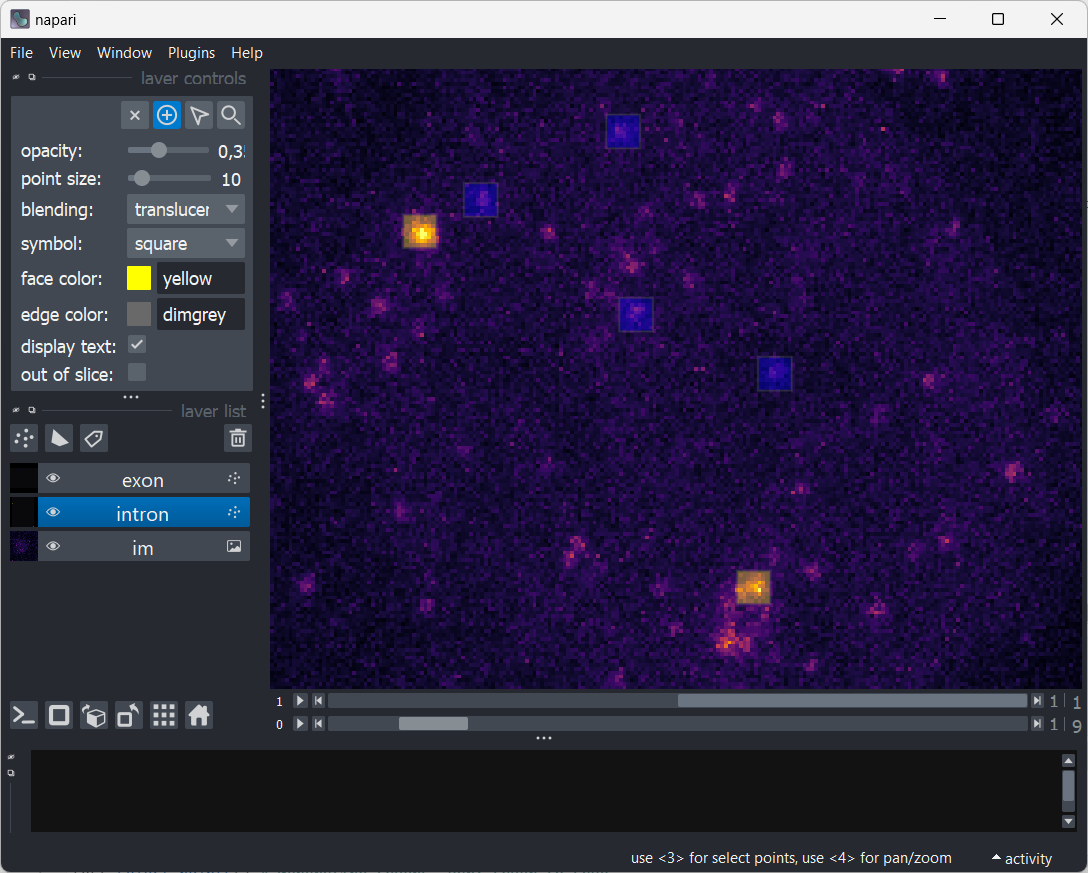

In [76]:
Image(filename= '0010_python.png')

In [77]:
test.select_points() # Generating layers, var: layer_to_save

## Saving layers selected previously

In [78]:
test.saving_layers() # Saving layers into csv for backup and generating Excel with coordinates information, var: DFs

In [79]:
os.startfile(test.folder)

## Showing Data coordinates collected

In [80]:
test.DFs

,name,date,gene,serie,drugN,drug,layer,slice,channel,Y,X,Y0,Y1,X0,X1
0,20230101_GENE1_002_1_DRUG1,20230101,GENE1,002,1,DRUG1,intron,1.0,1.0,240.714718,332.765021,236,246,328,338
1,20230101_GENE1_103_2_DRUG2,20230101,GENE1,103,2,DRUG2,intron,6.0,1.0,238.806940,255.500000,234,244,250,260
2,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,intron,0.0,1.0,235.468328,465.355612,230,240,460,470
3,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron,5.0,1.0,247.391942,208.759432,242,252,204,214
4,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron,5.0,1.0,282.685841,244.530275,278,288,240,250
5,20230101_GENE1_203_3_DRUG3,20230101,GENE1,203,3,DRUG3,intron,10.0,1.0,293.655566,260.746390,289,299,256,266
6,20230101_GENE1_002_1_DRUG1,20230101,GENE1,002,1,DRUG1,exon,1.0,1.0,253.592222,406.214485,249,259,401,411
7,20230101_GENE1_002_1_DRUG1,20230101,GENE1,002,1,DRUG1,exon,1.0,1.0,254.069166,418.138100,249,259,413,423
8,20230101_GENE1_002_1_DRUG1,20230101,GENE1,002,1,DRUG1,exon,1.0,1.0,276.008617,309.871681,271,281,305,315
9,20230101_GENE1_002_1_DRUG1,20230101,GENE1,002,1,DRUG1,exon,1.0,1.0,127.201910,367.105030,122,132,362,372


## Plotting ROIs

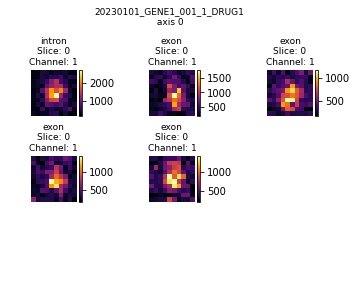

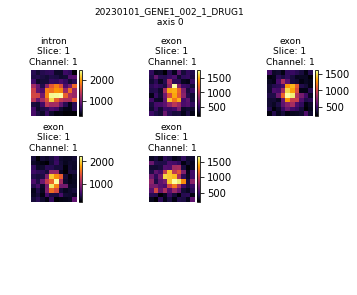

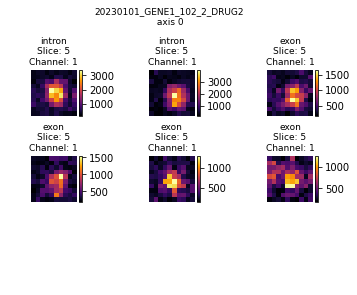

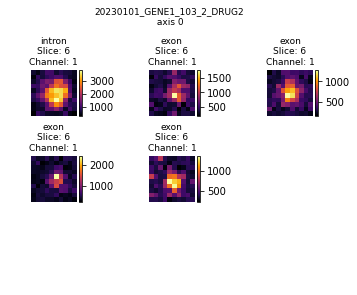

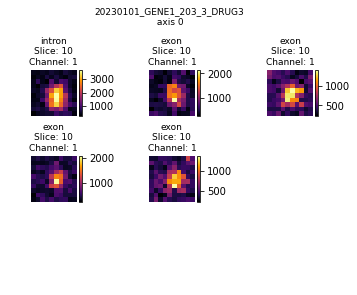

In [81]:
test.plotting_roi(axis=0, extension='svg')

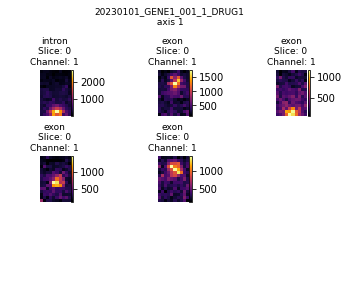

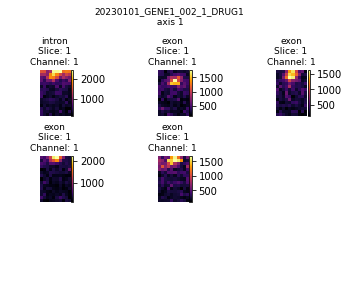

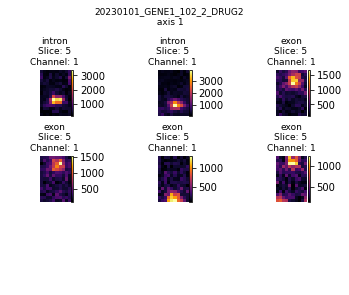

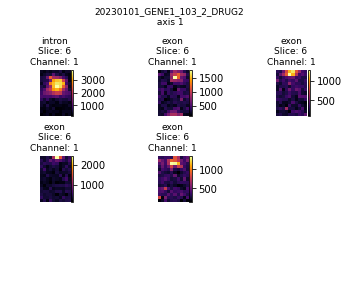

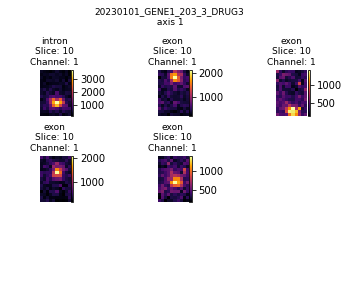

In [82]:
test.plotting_roi(axis=1, extension='svg')

## Saving roi info in DF and saving Excel with RAW results 

In [23]:
test.extract_rois_for_DF()
test.f_DF.head(5)

,name,date,gene,serie,drugN,drug,layer,slice,channel,Y,X,Y0,Y1,X0,X1,sum,max,mean,min,std
2,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,intron,0.0,1.0,235.468328,465.355612,230.0,240.0,460.0,470.0,304323.0,2656.0,202.88,50.0,250.29
10,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,exon,0.0,1.0,260.269446,386.659758,255.0,265.0,382.0,392.0,287507.0,1746.0,191.67,48.0,170.97
11,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,exon,0.0,1.0,269.331393,430.061714,264.0,274.0,425.0,435.0,238470.0,1164.0,158.98,49.0,135.75
12,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,exon,0.0,1.0,239.760829,400.014206,235.0,245.0,395.0,405.0,244049.0,1445.0,162.70,50.0,138.38
13,20230101_GENE1_001_1_DRUG1,20230101,GENE1,001,1,DRUG1,exon,0.0,1.0,210.667210,413.368654,206.0,216.0,408.0,418.0,291594.0,1409.0,194.40,48.0,166.54


# End of gene spot extraction (Go back to User Input to generate results for other genes)

# Collecting all results from Main Directory

In [36]:
results = [i for i in list(main_folder.glob("*xlsx")) if i.stem in [u.name for u in sets]]
rDFs = [pd.ExcelFile(i).parse('roi') for i in results]
rDFs = pd.concat(rDFs, axis=0)
rDFs.insert(loc=rDFs.columns.tolist().index('layer')+1, column='spot index', value = rDFs.groupby(['name', 'layer']).cumcount() + 1)
rDFs=rDFs.drop(['X', 'Y', 'Y0', 'Y1', 'X0', 'X1'], axis=1)
display(rDFs.head(5))

,name,date,gene,serie,drugN,drug,layer,spot index,slice,channel,sum,max,mean,min,std
0,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,intron,1,0.0,1.0,304323.0,2656.0,202.88,50.0,250.29
1,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,1,0.0,1.0,287507.0,1746.0,191.67,48.0,170.97
2,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,2,0.0,1.0,238470.0,1164.0,158.98,49.0,135.75
3,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,3,0.0,1.0,244049.0,1445.0,162.70,50.0,138.38
4,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,4,0.0,1.0,291594.0,1409.0,194.40,48.0,166.54


## Frequency

In [37]:
freq = defaultdict(list)

for name, group in rDFs.groupby(['gene', 'drug']):
    not_expressed = len(group[group['layer'].isna()])
    expressed = len(group[group['layer'] == 'intron'])
    freq['gene'].append(name[0])
    freq['drug'].append(name[1])
    freq['expressed'].append(expressed)
    freq['not expressed'].append(not_expressed)

freq = pd.DataFrame(freq)
freq['total'] = freq.apply(lambda x: x['expressed'] + x['not expressed'], axis=1)
freq['frequency'] = freq.apply(lambda x: round(x['expressed']/x['total'], 2), axis=1)
display(freq)

,gene,drug,expressed,not expressed,total,frequency
0,GENE1,DRUG1,2,2,4,0.50
1,GENE1,DRUG2,3,2,5,0.60
2,GENE1,DRUG3,1,3,4,0.25
3,GENE2,DRUG1,5,1,6,0.83
4,GENE2,DRUG2,0,4,4,0.00
5,GENE2,DRUG3,5,1,6,0.83


## Intron and Exon counts

In [38]:
intron_counts = []
exon_counts = [] # to keep control avg exon was done similarly

for name, group in rDFs.groupby(['gene', 'drug']):
    intronCount = group[group['layer'] == 'intron'].groupby(['name']).count().reset_index()[['name', 'sum']]
    exonCount = group[group['layer'] == 'exon'].groupby(['name']).count().reset_index()[['name', 'sum']]
    intron_counts.append(intronCount)
    exon_counts.append(exonCount)
    
intron_counts = pd.concat(intron_counts).reset_index(drop=True)
intron_counts.columns = ['name', 'intron number']

exon_counts = pd.concat(exon_counts).reset_index(drop=True)
exon_counts.columns = ['name', 'exon number']

counts = pd.merge(intron_counts, exon_counts, on=['name'])

display(counts)

,name,intron number,exon number
0,20230101_GENE1_001_1_DRUG1,1,4
1,20230101_GENE1_002_1_DRUG1,1,4
2,20230101_GENE1_102_2_DRUG2,2,4
3,20230101_GENE1_103_2_DRUG2,1,4
4,20230101_GENE1_203_3_DRUG3,1,4
5,20230101_GENE2_001_1_DRUG1,1,4
6,20230101_GENE2_002_1_DRUG1,2,4
7,20230101_GENE2_004_1_DRUG1,2,4
8,20230101_GENE2_201_3_DRUG3,2,4
9,20230101_GENE2_203_3_DRUG3,1,4


## Exon average

In [39]:

exon_average = []
getloc = lambda x: rDFs.columns.tolist().index(x)
for name, group in rDFs.groupby(['gene', 'drug']):
    exonavg = group[group['layer'] == 'exon'].groupby(['name']).mean().reset_index()
    exonavg.insert(loc=getloc("layer"), column='layer', value='exon')
    exonavg.insert(loc=getloc("gene"), column='gene', value=name[0])
    exonavg.insert(loc=getloc("drug"), column='drug', value=name[1])
    exon_average.append(exonavg)

    
exon_average = pd.concat(exon_average).reset_index(drop=True)
# exon_average.columns = ['name', 'exon avg']
display(exon_average)


,name,date,gene,serie,drugN,drug,spot index,slice,layer,channel,sum,max,mean,min,std
0,20230101_GENE1_001_1_DRUG1,20230101.0,GENE1,1.0,1.0,DRUG1,2.5,0.0,exon,1.0,265405.00,1441.00,176.9375,48.75,152.9100
1,20230101_GENE1_002_1_DRUG1,20230101.0,GENE1,2.0,1.0,DRUG1,2.5,1.0,exon,1.0,294436.75,1813.75,196.2925,48.50,185.9000
2,20230101_GENE1_102_2_DRUG2,20230101.0,GENE1,102.0,2.0,DRUG2,2.5,5.0,exon,1.0,252416.75,1426.25,168.2775,46.50,155.9875
3,20230101_GENE1_103_2_DRUG2,20230101.0,GENE1,103.0,2.0,DRUG2,2.5,6.0,exon,1.0,276507.00,1701.75,184.3375,48.25,146.3775
4,20230101_GENE1_203_3_DRUG3,20230101.0,GENE1,203.0,3.0,DRUG3,2.5,10.0,exon,1.0,346220.75,1738.25,230.8150,48.00,180.1300
5,20230101_GENE2_001_1_DRUG1,20230101.0,GENE2,1.0,1.0,DRUG1,2.5,0.0,exon,1.0,154647.75,982.00,127.2800,43.00,105.1850
6,20230101_GENE2_002_1_DRUG1,20230101.0,GENE2,2.0,1.0,DRUG1,2.5,1.0,exon,1.0,133437.75,790.50,109.8250,41.50,83.8050
7,20230101_GENE2_004_1_DRUG1,20230101.0,GENE2,4.0,1.0,DRUG1,2.5,3.0,exon,1.0,187061.75,1267.00,153.9600,43.25,139.3850
8,20230101_GENE2_201_3_DRUG3,20230101.0,GENE2,201.0,3.0,DRUG3,2.5,8.0,exon,1.0,153172.75,723.25,126.0675,43.00,85.5775
9,20230101_GENE2_203_3_DRUG3,20230101.0,GENE2,203.0,3.0,DRUG3,2.5,10.0,exon,1.0,134735.00,808.50,110.8925,42.00,83.5725


## Introns separation

In [40]:
intron_tables = []
for name, group in rDFs.groupby(['gene', 'drug']):
    introns = group[group['layer'] == 'intron']
    intron_tables.append(introns)
    
intron_tables = pd.concat(intron_tables).reset_index(drop=True)

display(intron_tables)    

,name,date,gene,serie,drugN,drug,layer,spot index,slice,channel,sum,max,mean,min,std
0,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,intron,1,0.0,1.0,304323.0,2656.0,202.88,50.0,250.29
1,20230101_GENE1_002_1_DRUG1,20230101,GENE1,2,1,DRUG1,intron,1,1.0,1.0,430123.0,2449.0,286.75,52.0,320.09
2,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron,1,5.0,1.0,402526.0,3350.0,268.35,51.0,327.93
3,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron,2,5.0,1.0,366293.0,3918.0,244.20,51.0,351.03
4,20230101_GENE1_103_2_DRUG2,20230101,GENE1,103,2,DRUG2,intron,1,6.0,1.0,733127.0,3773.0,488.75,52.0,584.93
5,20230101_GENE1_203_3_DRUG3,20230101,GENE1,203,3,DRUG3,intron,1,10.0,1.0,485252.0,3659.0,323.50,50.0,397.82
6,20230101_GENE2_001_1_DRUG1,20230101,GENE2,1,1,DRUG1,intron,1,0.0,1.0,400054.0,2532.0,329.26,43.0,333.70
7,20230101_GENE2_002_1_DRUG1,20230101,GENE2,2,1,DRUG1,intron,1,1.0,1.0,286782.0,1960.0,236.03,44.0,294.94
8,20230101_GENE2_002_1_DRUG1,20230101,GENE2,2,1,DRUG1,intron,2,1.0,1.0,237979.0,1889.0,195.87,43.0,176.26
9,20230101_GENE2_004_1_DRUG1,20230101,GENE2,4,1,DRUG1,intron,1,3.0,1.0,326320.0,2149.0,268.58,38.0,319.68


# Relative expression (Intron / Exon Average)

In [41]:
exons = []
introns = []
for ix, row in intron_tables.iterrows():
    exon = exon_average[(exon_average.name == row['name'])]
    intron = intron_tables[(intron_tables.name == row['name']) & (intron_tables['spot index'] == row['spot index'])]
    exons.append(exon)
    introns.append(intron)


exons = pd.concat(exons)
exons = exons.reset_index(drop=True)
introns = pd.concat(introns)
introns = introns.reset_index(drop=True)
r = dataframe_division(df1=introns, df2=exons, columns_to_exclude=['name','date','gene','serie','drugN','drug','layer','spot index','slice','channel'])
r['layer'] = "intron/exon avg"
display(r)

,name,date,gene,serie,drugN,drug,layer,spot index,slice,channel,sum,max,mean,min,std
0,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,intron/exon avg,1,0.0,1.0,1.146636,1.843164,1.146620,1.025641,1.636845
1,20230101_GENE1_002_1_DRUG1,20230101,GENE1,2,1,DRUG1,intron/exon avg,1,1.0,1.0,1.460833,1.350241,1.460830,1.072165,1.721840
2,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron/exon avg,1,5.0,1.0,1.594688,2.348817,1.594687,1.096774,2.102284
3,20230101_GENE1_102_2_DRUG2,20230101,GENE1,102,2,DRUG2,intron/exon avg,2,5.0,1.0,1.451144,2.747064,1.451174,1.096774,2.250373
4,20230101_GENE1_103_2_DRUG2,20230101,GENE1,103,2,DRUG2,intron/exon avg,1,6.0,1.0,2.651387,2.217129,2.651387,1.077720,3.996038
5,20230101_GENE1_203_3_DRUG3,20230101,GENE1,203,3,DRUG3,intron/exon avg,1,10.0,1.0,1.401568,2.104991,1.401555,1.041667,2.208516
6,20230101_GENE2_001_1_DRUG1,20230101,GENE2,1,1,DRUG1,intron/exon avg,1,0.0,1.0,2.586872,2.578411,2.586895,1.000000,3.172506
7,20230101_GENE2_002_1_DRUG1,20230101,GENE2,2,1,DRUG1,intron/exon avg,1,1.0,1.0,2.149182,2.479443,2.149146,1.060241,3.519360
8,20230101_GENE2_002_1_DRUG1,20230101,GENE2,2,1,DRUG1,intron/exon avg,2,1.0,1.0,1.783446,2.389627,1.783474,1.036145,2.103216
9,20230101_GENE2_004_1_DRUG1,20230101,GENE2,4,1,DRUG1,intron/exon avg,1,3.0,1.0,1.744451,1.696133,1.744479,0.878613,2.293504


# Saving results

In [42]:
writting_excel(DF=[rDFs, counts, intron_tables, exon_average, r, freq], 
               sheet_name=['raw', 'counts', 'intron', 'exon average', 'relative expression', 'frequency'],
               pathname=main_folder / f"{today}_relative_expression.xlsx")

# Open dataset folder

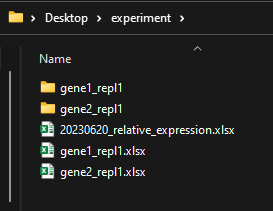

In [58]:
Image(filename= '0011_explorer.png')

In [ ]:
os.startfile(test.folder)

In [47]:
display(rDFs)

,name,date,gene,serie,drugN,drug,layer,spot index,slice,channel,sum,max,mean,min,std
0,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,intron,1,0.0,1.0,304323.0,2656.0,202.88,50.0,250.29
1,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,1,0.0,1.0,287507.0,1746.0,191.67,48.0,170.97
2,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,2,0.0,1.0,238470.0,1164.0,158.98,49.0,135.75
3,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,3,0.0,1.0,244049.0,1445.0,162.70,50.0,138.38
4,20230101_GENE1_001_1_DRUG1,20230101,GENE1,1,1,DRUG1,exon,4,0.0,1.0,291594.0,1409.0,194.40,48.0,166.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,20230101_GENE2_204_3_DRUG3,20230101,GENE2,204,3,DRUG3,intron,2,11.0,1.0,369168.0,1745.0,303.84,45.0,282.79
36,20230101_GENE2_204_3_DRUG3,20230101,GENE2,204,3,DRUG3,exon,1,11.0,1.0,131372.0,1108.0,108.13,42.0,81.87
37,20230101_GENE2_204_3_DRUG3,20230101,GENE2,204,3,DRUG3,exon,2,11.0,1.0,153703.0,892.0,126.50,42.0,84.64
38,20230101_GENE2_204_3_DRUG3,20230101,GENE2,204,3,DRUG3,exon,3,11.0,1.0,167862.0,779.0,138.16,45.0,100.35


# Overview

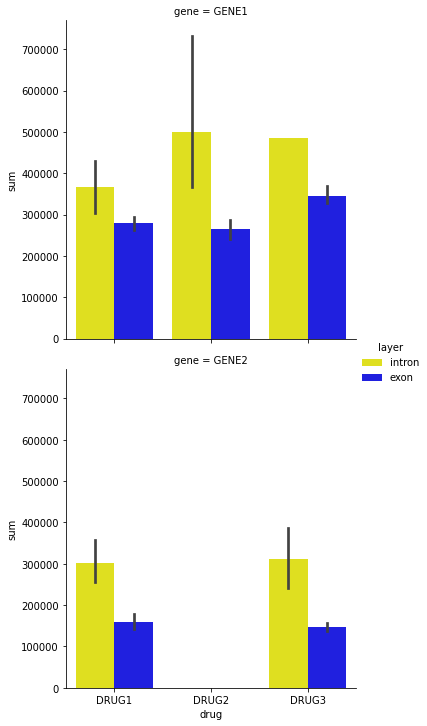

In [60]:
sns.catplot(data=rDFs, x='drug', y='sum', hue='layer',row='gene', kind='bar', palette=['yellow', 'blue'])
plt.savefig(main_folder / f"Overview_data.svg", dpi=300, bbox_inches = 'tight');

# Renaming tool (Make sure you have a backup of these pictures, this action it is dangerous)

First make sure the new name makes sense and it is according with what you expect. By running the next cell. When being sure of the change to be done, uncomment the line marked with an arrow and run it again. Repeat this proccess as many times you need to correct for your naming convention.

In [54]:
folder = Path(r"C:\Users\User\Desktop\experiment\gene2_repl1")
files = list(folder.rglob("*.tif"))

print("Old name                       >>> New name")
print("-"*65)
for i in files:
    newname = i.name.replace("target", "replacement")
    newpath = i.parent / newname
#     i.rename(newpath) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Uncomment to rename
    print(i.name, ">>>", newname)

Old name                       >>> New name
-----------------------------------------------------------------
20230101_GENE2_001_1_DRUG1.tif >>> 20230101_GENE2_001_1_DRUG1.tif
20230101_GENE2_002_1_DRUG1.tif >>> 20230101_GENE2_002_1_DRUG1.tif
20230101_GENE2_003_1_DRUG1.tif >>> 20230101_GENE2_003_1_DRUG1.tif
20230101_GENE2_004_1_DRUG1.tif >>> 20230101_GENE2_004_1_DRUG1.tif
20230101_GENE2_101_2_DRUG2.tif >>> 20230101_GENE2_101_2_DRUG2.tif
20230101_GENE2_102_2_DRUG2.tif >>> 20230101_GENE2_102_2_DRUG2.tif
20230101_GENE2_103_2_DRUG2.tif >>> 20230101_GENE2_103_2_DRUG2.tif
20230101_GENE2_104_2_DRUG2.tif >>> 20230101_GENE2_104_2_DRUG2.tif
20230101_GENE2_201_3_DRUG3.tif >>> 20230101_GENE2_201_3_DRUG3.tif
20230101_GENE2_202_3_DRUG3.tif >>> 20230101_GENE2_202_3_DRUG3.tif
20230101_GENE2_203_3_DRUG3.tif >>> 20230101_GENE2_203_3_DRUG3.tif
20230101_GENE2_204_3_DRUG3.tif >>> 20230101_GENE2_204_3_DRUG3.tif
